In [ ]:
!pip install DMBA mord

In [ ]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
import math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
print(sys.version)
print('The scikit-learn version is {}.'.format(sklearn.__version__))

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
The scikit-learn version is 1.5.2.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA = Path('/content/drive/My Drive/Colab Notebooks/Analytics Competition/')

In [ ]:
train_X = pd.read_csv(DATA / 'train_X.csv')
valid_X = pd.read_csv(DATA / 'valid_X.csv')
train_y = pd.read_csv(DATA / 'train_y.csv')
valid_y = pd.read_csv(DATA / 'valid_y.csv')

train_X.head()

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,BalanceGross,GrAppv,Franchise_Dummy,RevLineCr_N,...,State_TN,State_VT,State_WA,State_WI,State_WV,IndustryCode_Other,IndustryCode_Real_Estate,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,1996,84,8,0,0,85000.0,0.0,85000.0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,2002,84,7,1,7,50000.0,0.0,50000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2005,68,11,0,0,150000.0,0.0,150000.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2005,69,15,0,15,11600.0,0.0,11600.0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1999,240,14,7,7,221000.0,0.0,221000.0,0,1,...,0,0,0,0,0,0,0,1,0,0


Pre-Processing

In [ ]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)
train_X = pd.DataFrame(train_X_scaled, columns=train_X.columns, index=train_X.index)
valid_X = pd.DataFrame(valid_X_scaled, columns=valid_X.columns, index=valid_X.index)

# Logistic Regression

Logistic Regression is used to predict the probablity of a binary outcome. Linear Regression predicts continous values and for this reason, it does not apply to any classification models. We will run two models to compare their preformance metrics with our desired high f1 score. When running a logistic regression, you must choose a penalty and solver. We will review what this means below.

**Penalty**

A penalty is a constraint or rule that prevents a model from being too complex. These penalties are added to the loss function.

Ridge Regression adds a penalty equal to the square of the magnitude of the coefficients and is called the L2 penalty. This penalty will shrink the coefficients towards 0, but not exactly to 0. This helps prevent overfitting. This L2 penalty aids in reducing multicollinearity and handles high dimensional data aswell.

Lasso Regression adds a penatly equal to the absolute value of the magnitude of the coeffcients. It is called the L1 penalty. Lasso regression can shrink some coeffcients exactly to 0. This is in a sence, selecting relvanet features to the model which are most important. It is usefull when you want to reduce the number of features in your dataset.

**Solver**

A solver is an algorithm that will find the optimal values for the coefficients in a Logistic Regression Model. Different solvers will have different strategies and benefits. There can be many pros/cons to any solver you may use. Saga is efficent with larger data sets however may not produce desired results.. Liblinear may struggle with a data set this large but prduce better models. Liblinear also alligns well with L1 and L2 regularization and alligns with the Ridge/Lasso Regression Approaches. For these reasons, we will use Liblinear.

In [ ]:
logit_reg_ridge = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', random_state=1)
logit_reg_ridge.fit(train_X, train_y.values.ravel())

print('intercept ', logit_reg_ridge.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg_ridge.coef_[0]}, index=train_X.columns).transpose())
print()
print('AIC', AIC_score(valid_y.values.ravel(), logit_reg_ridge.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -2.4906444921490367
       ApprovalFY      Term    NoEmp  CreateJob  RetainedJob  \
coeff    0.015502 -2.026606 -0.61971   0.339876    -0.241687   

       DisbursementGross  BalanceGross    GrAppv  Franchise_Dummy  \
coeff          -0.079273     -0.194561  0.261181         0.011865   

       RevLineCr_N  ...  State_TN  State_VT  State_WA  State_WI  State_WV  \
coeff     0.098926  ...  0.032457 -0.087142  -0.04494 -0.065023   0.00109   

       IndustryCode_Other  IndustryCode_Real_Estate  UrbanRural_0  \
coeff            0.040127                  0.055204     -0.297894   

       UrbanRural_1  UrbanRural_2  
coeff      0.234853      0.079511  

[1 rows x 67 columns]

AIC 344624.4980950133


In [ ]:
predictions = logit_reg_ridge.predict(train_X)
f1 = f1_score(train_y, predictions)
classificationSummary(train_y, predictions)

print(f"F1 Score: {f1}")

Confusion Matrix (Accuracy 0.8468)

       Prediction
Actual      0      1
     0 433905  10999
     1  71639  22955
F1 Score: 0.35714285714285715


In [ ]:
predictions = logit_reg_ridge.predict(valid_X)
f1 = f1_score(valid_y, predictions)
classificationSummary(valid_y, predictions)

print(f"F1 Score: {f1}")

Confusion Matrix (Accuracy 0.8474)

       Prediction
Actual      0      1
     0 289384   7318
     1  47559  15405
F1 Score: 0.3595644613535309


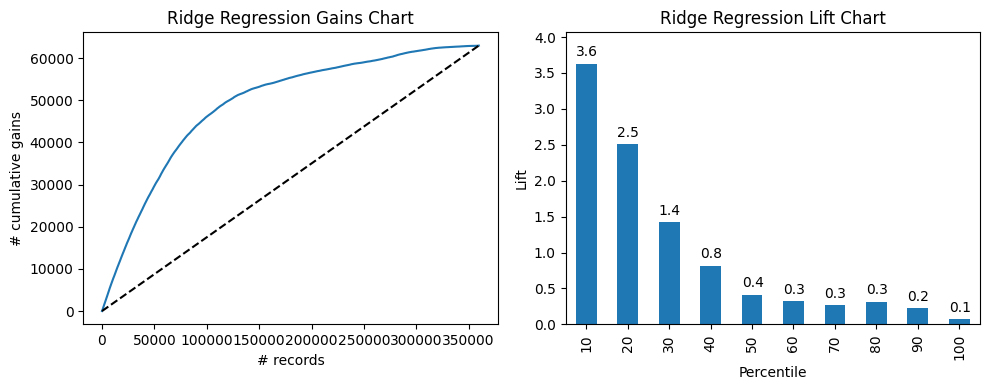

In [ ]:
logit_reg_ridge_proba = logit_reg_ridge.predict_proba(valid_X)
logit_result_ridge = pd.DataFrame({'actual': valid_y.values.ravel(), 'p(0)': [p[0] for p in logit_reg_ridge_proba], 'p(1)': [p[1] for p in logit_reg_ridge_proba]})
logit_result_ridge = logit_result_ridge.sort_values(by=['p(1)'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(logit_result_ridge.actual, ax=axes[0])
axes[0].set_title("Ridge Regression Gains Chart")

liftChart(logit_result_ridge.actual, title="Ridge Regression Lift Chart", ax=axes[1])

plt.tight_layout()
plt.show()

In the gains and lifts chart, we see an initial steep boost of interpretive power but as the amount of records grows a strong plateu. This indicates this model is strong at idneifying smaller data sets but loses its predictive power as the number of records is bigger than around 15,000 records.

In [ ]:
best_cutoff_ridge = 0
best_f1_score = 0

for cutoff in np.arange(0.01, 1, 0.01):
    predicted_probs = logit_reg_ridge.predict_proba(valid_X)[:, 1]
    predictions = (predicted_probs >= cutoff).astype(int)

    f1 = f1_score(valid_y['Default_CHGOFF'], predictions)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_cutoff_ridge = cutoff

print(f"Best cutoff for Ridge Regression (F1-score): {best_cutoff_ridge}")

Best cutoff for Ridge Regression (F1-score): 0.29000000000000004


In [ ]:
# Lasso Regression
logit_reg_lasso = LogisticRegression(penalty="l1", C=1, solver='liblinear', random_state=1)
logit_reg_lasso.fit(train_X, train_y.values.ravel())

print('intercept ', logit_reg_lasso.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg_lasso.coef_[0]}, index=train_X.columns).transpose())
print()
print('AIC', AIC_score(valid_y.values.ravel(), logit_reg_lasso.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -2.490591649344317
       ApprovalFY      Term     NoEmp  CreateJob  RetainedJob  \
coeff     0.01546 -2.026337 -0.620095   0.331007    -0.232769   

       DisbursementGross  BalanceGross    GrAppv  Franchise_Dummy  \
coeff          -0.078745     -0.248997  0.260574         0.011851   

       RevLineCr_N  ...  State_TN  State_VT  State_WA  State_WI  State_WV  \
coeff     0.046579  ...  0.032449 -0.087103 -0.044913 -0.064996  0.001078   

       IndustryCode_Other  IndustryCode_Real_Estate  UrbanRural_0  \
coeff            0.043229                  0.056119     -0.345931   

       UrbanRural_1  UrbanRural_2  
coeff       0.18471      0.047195  

[1 rows x 67 columns]

AIC 344624.4980950133


In [ ]:
predictions = logit_reg_lasso.predict(train_X)
f1 = f1_score(train_y, predictions)
classificationSummary(train_y, predictions)

print(f"F1 Score: {f1}")

Confusion Matrix (Accuracy 0.8468)

       Prediction
Actual      0      1
     0 433909  10995
     1  71645  22949
F1 Score: 0.3570772845384244


In [ ]:
predictions = logit_reg_lasso.predict(valid_X)
f1 = f1_score(valid_y, predictions)
classificationSummary(valid_y, predictions)

print(f"F1 Score: {f1}")

Confusion Matrix (Accuracy 0.8474)

       Prediction
Actual      0      1
     0 289387   7315
     1  47562  15402
F1 Score: 0.3595196134498897


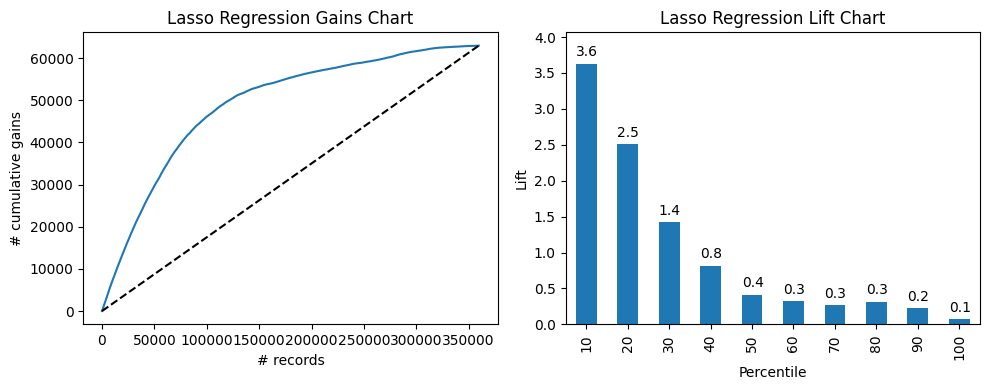

In [ ]:
logit_reg_lasso_proba = logit_reg_lasso.predict_proba(valid_X)
logit_result_lasso = pd.DataFrame({'actual': valid_y.values.ravel(), 'p(0)': [p[0] for p in logit_reg_lasso_proba], 'p(1)': [p[1] for p in logit_reg_lasso_proba]})
logit_result_lasso = logit_result_lasso.sort_values(by=['p(1)'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(logit_result_lasso.actual, ax=axes[0])
axes[0].set_title("Lasso Regression Gains Chart")  # Set title using axes object

liftChart(logit_result_lasso.actual, title="Lasso Regression Lift Chart", ax=axes[1])

plt.tight_layout()
plt.show()

These charts show stronger intial predictive power which falls off as the number of samples grows.The model is effective at prioritizing defaults in the top-ranked records (high predicted probabilities), but its ability to distinguish between defaults and non-defaults diminishes as more records are considered.

In [ ]:
from sklearn.metrics import f1_score

best_cutoff_lasso = 0
best_f1_score = 0

for cutoff in np.arange(0.01, 1, 0.01):
    predicted_probs = logit_reg_lasso.predict_proba(valid_X)[:, 1]
    predictions = (predicted_probs >= cutoff).astype(int)

    f1 = f1_score(valid_y['Default_CHGOFF'], predictions)

    if f1 > best_f1_score:
        best_f1_score = f1
        best_cutoff_lasso = cutoff

print(f"Best cutoff for Lasso Regression (F1-score): {best_cutoff_lasso}")

Best cutoff for Lasso Regression (F1-score): 0.29000000000000004


**Conclusions**

The best cutoff for both the Ridge and Lasso Regressions would be 0.29000 on the basis of balance between Recall and Precision. This F1 score will balance the potential defaults with the chance of lost profit. However, neither of these models seem great for our future predictions. With such low F1 scores, these models would struggle with balancing the consequnces and maxmiszing profit. We have already seen better results from Decision Trees and will continute to compare the preformance of other modeling techniques.

Outside of the context, for sheer predictive power we can compare the models.

If you prioritize focusing on the riskiest (top 10%-20%) records, where early gains and high lift are most critical, Lasso Regression is better. It has a sharper initial rise in the Gains Chart and a higher lift in the top deciles. However,
if you aim for a more balanced model that performs well across a larger portion of the dataset (top 30%-40%), with broader application, Ridge Regression is better. This is because its gains chart flattens less quickly, and its lift remains stable over a wider range.